# Predicting Bike Rentals in Washington D.C.

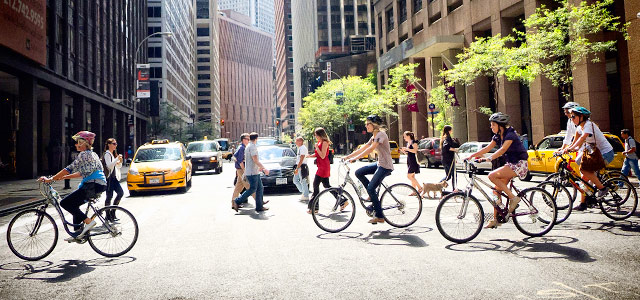

## Introduction
On-demand bike rentals have become a major trend in cities across the U.S. where within a mile or two of wherever a resident might be within the city, and especially city centers, they likely will find a self-service bike rental kiosk. There are considerations a company or a city might take to ensure that bicycle demand is being met where and when they are needed most. In this project we will attempt to predict this demand using linear regression and descision trees.

## Results
### Data Set Analysis
* There are more rentals in 2012 than 2011, research shows that Washington D.C. expanded their bikeshare program at the end of 2011.
* Warm weather increases rentals and peaks in Summer Months
* Registered and casual user groups have an inverse weekday/weekend relationship, with registered users having consistent usage throughout the work week.
* Registered user rentals peak during commuting hours (7:00-9:00 a.m. and 6:00-7:00 p.m.).
* Casual user rentals follow a normal distribution between 7:00 am and midnight with peak usage between noon and 6:00 p.m.
* Extreme weather causes a drop in bikeshare usage, though registered users are more resilient. 

### Predictive Models
Our goal was to create a predictive regression model for bike rental demand for our three cohorts (total count, registered count, and casual count). We used three algorithms (linear regression, decision trees, and random forests). Our success metrics were RMSE, MAE, and R2. 

#### Performance
* Random Forests performed best
    * Best model for total prediction:
        * Random Forest with 350 estimators - RMSE: 44.90, MAE: 26.04 , R2: 0.94
    * Best model for casual prediction:
        * Random Forest with random grid hyperparameter selection & k-fold - RMSE: 14.14, MAE: 8.35, R2: 0.91
    * Best model for registered prediction:
        * Random Forest with 350 estimators - RMSE: 37.13, MAE: 20.96, R2: 0.94 
        
Predicting the total users is more accurate than trying to predict the casual and registered user groups. Across all models, the R2 for the casual group was slightly lower than that of total and registered. This indicates that the models are less able to explain the variance in predictions with the features used, and there is an opportunity to improve the predictions with further feature engineering targeted at the casual group. 



## Washington D.C. Bike Rental Dataset Overview
Our dataset will focus on Washington D.C., which collects detailed data on bike rentals, from 2011 to 2012. The dataset was compiled in csv format by Hadi Fanee-T, and can be downloaded from the [University of California, Irvine's](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) website. 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# read in the data
rentals = pd.read_csv("bike_rental_hour.csv")

In [3]:
rentals.head(2)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40


In [4]:
rentals.tail(2)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


In [5]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


Our data consists of 17 columns and 17,379 rows of data. There are 16 numeric columns and 1 string-object column. There are no apparent missing values. Each row in the dataset is an one-hour increment snapshot and takes place over two years total, starting 1/1/2011 and ending 12/31/2012.

The columns follow the following descriptions:  
* instant - A unique sequential ID number for each row
* dteday - The date of the rentals
* season - The season in which the rentals occurred
* yr - The year the rentals occurred
* mnth - The month the rentals occurred
* hr - The hour the rentals occurred
* holiday - Whether or not the day was a holiday
* weekday - The day of the week (as a number, 0 to 7)
* workingday - Whether or not the day was a working day
* weathersit - The weather (as a categorical variable)  
    1: clear or few clouds  
    2: mist or cloudy  
    3: light rain, light snow, thunderstorm  
    4: heavy rain, snow, ice pellets, fog  
* temp - The temperature, on a 0-1 scale
* atemp - The adjusted temperature
* hum - The humidity, on a 0-1 scale
* windspeed - The wind speed, on a 0-1 scale
* casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* registered - The number of registered riders (people who had already signed up)
* cnt - The total number of bike rentals (casual + registered)

The primary target for our predictive models will be the `cnt` column, which is the total number of bike rentals at a given hour. `casual` and `registered` columns will also be considered. 

### Transforming Time Metrics
Let's do some clean-up on dates so that we can more easily splice and run time-series analysis on our data. The related columns that we will evaluate are `dteday`, `yr`, `mnth`, and `hr`. Rather than changing each of these to datetime, we can create a single datetime object with `dteday` and `hr` columns so that we can easily access the underlying time data with datetime logic. Let's add the `hr` and `dteday` columns now.

In [6]:
# convert the hr column to string, combine it with dteday in a format datetime understands
rentals['hr'] = rentals['hr'].astype(str)
rentals['datetime'] = rentals['dteday'] + ' ' + rentals['hr']+':00:00'
rentals['hr'] = rentals['hr'].astype(int) # return to int

# transform the new column to datetime
rentals['datetime'] = pd.to_datetime(rentals['datetime'])

In [7]:
rentals['datetime']

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
17374   2012-12-31 19:00:00
17375   2012-12-31 20:00:00
17376   2012-12-31 21:00:00
17377   2012-12-31 22:00:00
17378   2012-12-31 23:00:00
Name: datetime, Length: 17379, dtype: datetime64[ns]

Let's check the completeness of our dataset. There should be two years of hour by hour data.

In [8]:
two_yr_hr = 2*365*24
length_rentals = len(rentals)
print('dataset:', length_rentals)
print('expected:', two_yr_hr)
print('difference:', two_yr_hr - length_rentals)
print('missing days:', (two_yr_hr-length_rentals)/24)

dataset: 17379
expected: 17520
difference: 141
missing days: 5.875


We're missing just under six days of data. We will accept this discrepancy as it is not pervasive enough to have a strong adverse affect on predictions.

### Exploration
Let's complete some basic analysis to understand our timeseries, we're specifically interested in our primary target `cnt`.

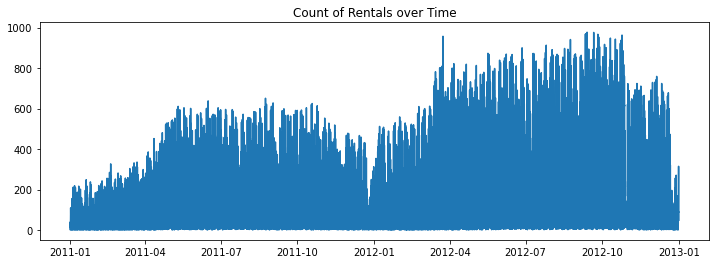

In [9]:
plt.figure(figsize = (12, 4))
plt.plot(rentals['datetime'], rentals['cnt'])
plt.title('Count of Rentals over Time')
plt.show()

A first impression of the distribution is that there are more rentals on average in 2012 than 2011. Some research shows that Washington expanded its [bikeshare program](https://en.wikipedia.org/wiki/Capital_Bikeshare#Expansion) at the end of 2011, which  logically makes sense as if there's more locations and bikes in service there are more potential users for the program. This may cause an undersirable influence in our predictions, however, we may be able to overcome by min-max scaling the count values in their respective years. 

Further, there are indications that seasonality plays a role, but at the hour-day-year granularity it is difficult to see what exactly is going on. Let's generate some histograms bucketed by day of week and month.

In [10]:
# create dataframes for our data splits
month_split = rentals.groupby("mnth")[["casual", "registered", "cnt"]].sum()
week_split = rentals.groupby("weekday")[["casual", "registered", "cnt"]].sum()
hour_split = rentals.groupby("hr")[["casual", "registered", "cnt"]].sum()

In [11]:
month_split

,casual,registered,cnt
mnth,,,
1,12042,122891,134933
2,14963,136389,151352
3,44444,184476,228920
4,60802,208292,269094
5,75285,256401,331686
6,73906,272436,346342
7,78157,266791,344948
8,72039,279155,351194
9,70323,275668,345991


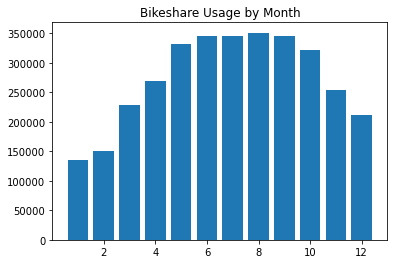

In [12]:
plt.bar(x = list(month_split.index), height = month_split['cnt'])
plt.title('Bikeshare Usage by Month')
plt.show()

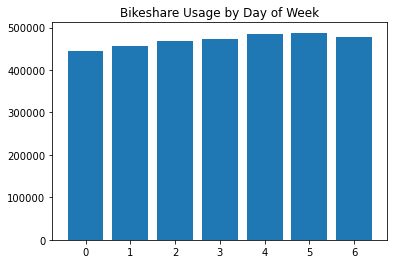

In [13]:
plt.bar(x = week_split.index, height = week_split['cnt'])
plt.title('Bikeshare Usage by Day of Week')
plt.show()

Our distributions indicate that there is a seasonal affect on bikeshare usage. Spring, Summer and Fall months have a relatively stable usage, but the winter months, November through February, have a drastic dropoff. 

The day of week also has an impact on usage, weekdays have a high and stable usage and weekends, Saturday and Sunday, have less use. 

Let's recreate the above bar charts but further split by `registered` and `casual`. This will give us indicators whether casual and registered users are more sensitive to seasonality.

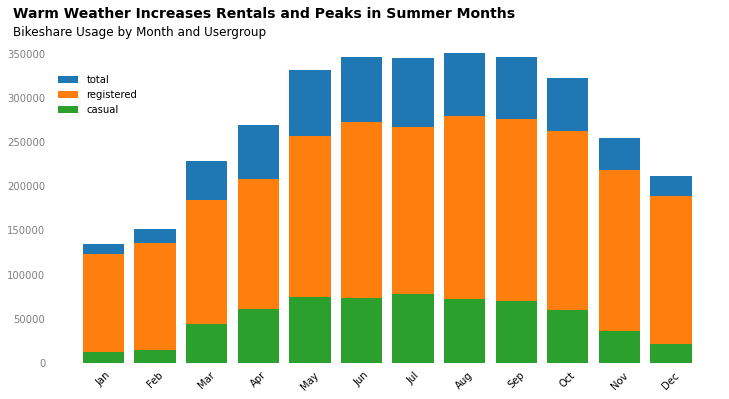

In [14]:
fig, ax = plt.subplots(figsize = (12,6))
ax.bar(month_split.index, month_split['cnt'], label = 'total')
ax.bar(month_split.index, month_split['registered'], label = 'registered')
ax.bar(month_split.index, month_split['casual'], label = 'casual')

#ax.set_yticks([300, 600, 900])
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation = 45)
ax.tick_params(left = False, bottom = False)
ax.tick_params(axis = 'y', colors = 'gray')

for location in ['left','right','top','bottom']:
    ax.spines[location].set_visible(False)

ax.text(-.75, 390000, 'Warm Weather Increases Rentals and Peaks in Summer Months', size=14, weight='bold')
ax.text(-.75, 370000, 'Bikeshare Usage by Month and Usergroup', size=12)

plt.legend(frameon = False, loc=(.003, .75))
plt.show()

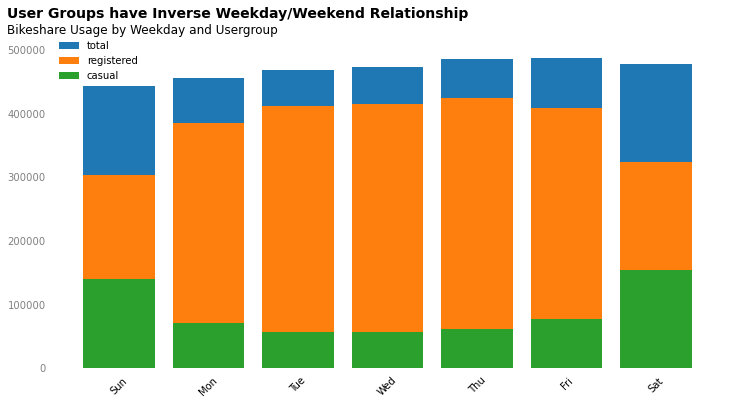

In [15]:
fig, ax = plt.subplots(figsize = (12,6))
ax.bar(week_split.index, week_split['cnt'], label = 'total')
ax.bar(week_split.index, week_split['registered'], label = 'registered')
ax.bar(week_split.index, week_split['casual'], label = 'casual')

#ax.set_yticks([300, 600, 900])
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(['Sun','Mon','Tue','Wed','Thu','Fri','Sat'], rotation = 45)
ax.tick_params(left = False, bottom = False)
ax.tick_params(axis = 'y', colors = 'gray')

for location in ['left','right','top','bottom']:
    ax.spines[location].set_visible(False)

    
ax.text(-1.25, 550000, 'User Groups have Inverse Weekday/Weekend Relationship', size=14, weight='bold')
ax.text(-1.25, 525000, 'Bikeshare Usage by Weekday and Usergroup', size=12)
#plt.title('Bikeshare Usage by Day of Week and Usergroup', size = 14, weight = 'bold')
plt.legend(loc = (0.003,0.87), frameon = False)
plt.show()

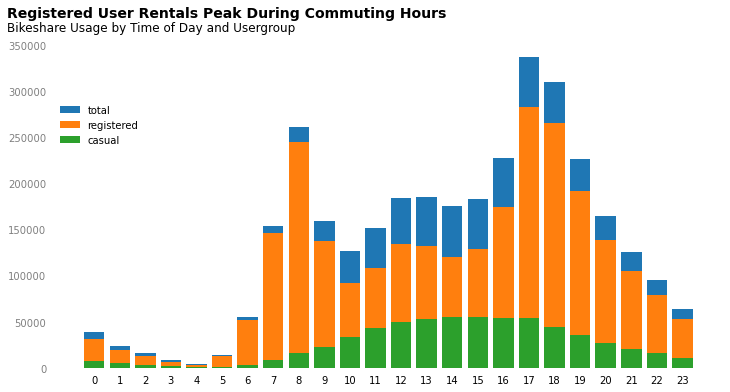

In [16]:
fig, ax = plt.subplots(figsize = (12,6))
ax.bar(hour_split.index, hour_split['cnt'], label = 'total')
ax.bar(hour_split.index, hour_split['registered'], label = 'registered')
ax.bar(hour_split.index, hour_split['casual'], label = 'casual')

#ax.set_ylim([0,1200])
#ax.set_yticks([300, 600, 900])
ax.set_xticks(list(range(0,24)))
ax.set_xticklabels(list(range(0,24)))
ax.tick_params(left = False, bottom = False)
ax.tick_params(axis = 'y', colors = 'gray')

for location in ['left','right','top','bottom']:
    ax.spines[location].set_visible(False)

ax.text(-3.4, 380000, 'Registered User Rentals Peak During Commuting Hours', size=14, weight='bold')
ax.text(-3.4, 365000, 'Bikeshare Usage by Time of Day and Usergroup', size=12)

plt.legend(loc = (0.003,0.67), frameon = False)

plt.show()

The behavior of bike rental user groups is different when cut along time. Because of this we may be able to get more accurate results if we predict the usage of these cohorts rather than just aiming at the total usage.

In [17]:
temp_split = rentals.groupby("temp")[["casual", "registered", "cnt"]].sum()
atemp_split = rentals.groupby("atemp")[["casual", "registered", "cnt"]].sum()
hum_split = rentals.groupby("hum")[["casual", "registered", "cnt"]].sum()
windspeed_split = rentals.groupby("windspeed")[["casual", "registered", "cnt"]].sum()

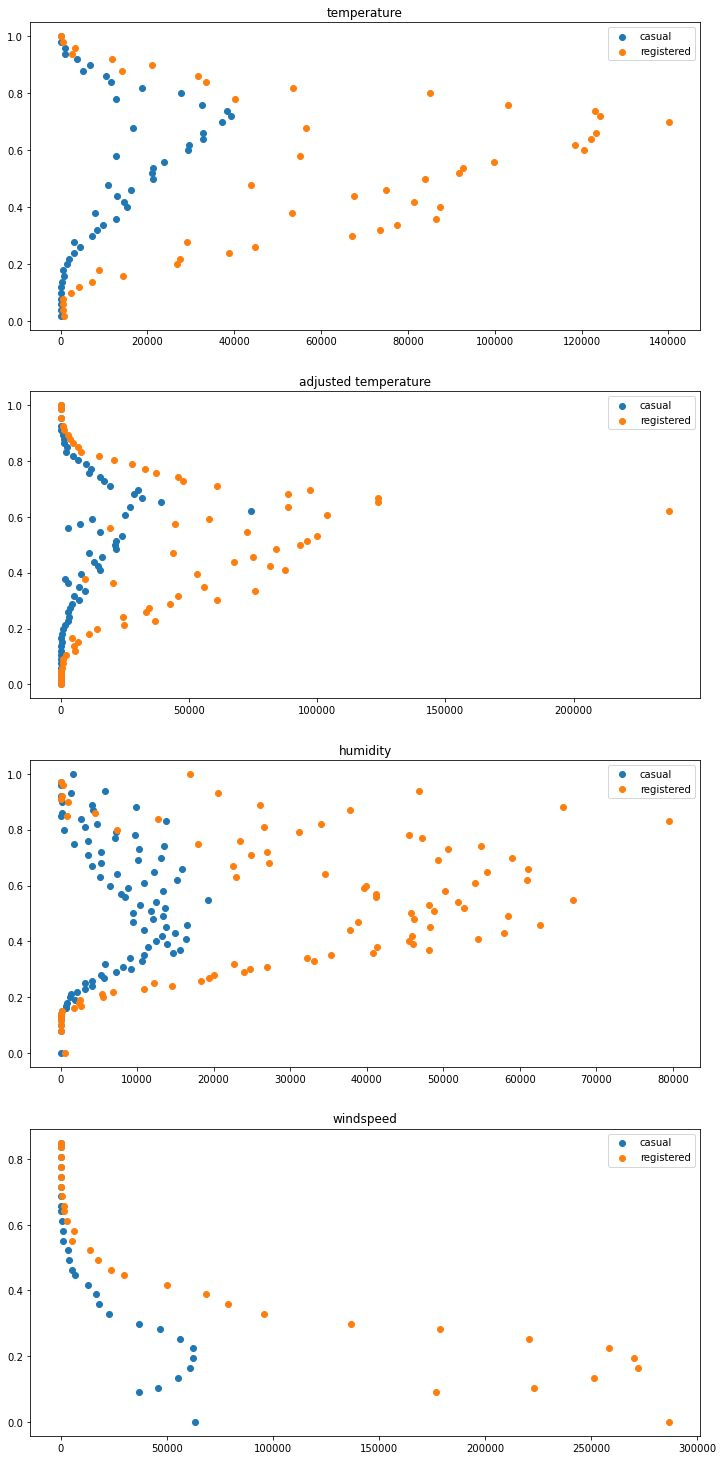

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, ncols = 1, figsize = (12,26))

for weather_feature, axes, title in zip([temp_split, atemp_split, hum_split, windspeed_split], [ax1, ax2, ax3, ax4], ['temperature','adjusted temperature', 'humidity','windspeed']):
    axes.set_title(title)
    for group in ['casual', 'registered']:
        axes.scatter(weather_feature[group], weather_feature.index, label = group)
    axes.legend()
        

plt.show()
                                 

Extreme weather (wind, humidity, temperature) causes a drop in bikeshare usage.

## Feature Selection
We will move forward with the plan to generate separate predictions for `cnt`, `registered` and `casual`. We will need to repeat the feature selection process for each category.

### Feature Creation
Based on our exploratory analysis there are some options to explore for feature creation.

#### Rush Hour
Registered users are more likely to use bicycles during commuting hours. We will define commuting hours as the hours between 7:00 through 9:00, and the hours 16:00 and 19:00. 

In [19]:
def rush_hour(time):
    if time in [7,8,9,16,17,18,19]:
        return True
    else:
        return False

In [20]:
rentals['rush_hour'] = rentals['hr'].apply(rush_hour)

#### Afternoon
Casual users are more likely to use bicycles during the afternoon. We will define the afternoon as the hours between 11:00 and 18:00.

In [21]:
def afternoon(time):
    if time in [11,12,13,14,15,16,17,18]:
        return True
    else:
        return False

In [22]:
rentals['afternoon'] = rentals['hr'].apply(afternoon)

#### Night
Both groups have a negative relationship with the nightime.

In [23]:
def night(time):
    if time in [0,1,2,3,4,5]:
        return True
    else:
        return False

In [24]:
rentals['night'] = rentals['hr'].apply(night)

#### General Time Frames
Let's create some general groupings for the time of day.

In [25]:
def time_label(time):
    if time in [6,7,8,9,10,11]:
        return 1
    elif time in [12,13,14,15,16,17]:
        return 2
    elif time in [18, 19, 20, 21, 22, 23]:
        return 3
    else:
        return 4

In [26]:
rentals['time_bin'] = rentals['hr'].apply(time_label)

#### Humidity
Let's categorize days that are too extreme on the humidity scale.

In [27]:
def nice_humidity(humidity):
    if humidity <= .2 or humidity >= .8:
        return False
    else:
        return True

rentals['nice_humidity'] = rentals['hum'].apply(nice_humidity)

#### Windspeed
Windy days has a negative effect on bikeshare usage.

In [28]:
def too_windy(windspeed):
    if windspeed > .3:
        return True
    else:
        return False

In [29]:
rentals['too_windy'] = rentals['windspeed'].apply(too_windy)

#### Temperature
If the temperature is not ideal.

In [30]:
def nice_temp(temperature):
    if temperature <= .2 or temperature >= .8:
        return False
    else:
        return True

In [31]:
rentals['nice_temp'] = rentals['temp'].apply(nice_temp)

### Target Correlations
One basic way to identify which columns will be good feature candidates for our machine learning algorithms is to look at correlations with the target metric. Too many features can result in an overfit model, so fewer, but well correlated features are usually desirable.

#### Total Count Correlations

In [32]:
cnt_feature_correlations = abs(rentals.corr()['cnt'].drop(['cnt', 'instant', 'registered','casual'])).sort_values(ascending = False)
cnt_feature_correlations

night            0.518261
rush_hour        0.494793
afternoon        0.436234
temp             0.404772
atemp            0.400929
hr               0.394071
time_bin         0.378318
hum              0.322911
yr               0.250495
nice_humidity    0.249086
season           0.178056
weathersit       0.142426
mnth             0.120638
windspeed        0.093234
too_windy        0.032652
holiday          0.030927
workingday       0.030284
weekday          0.026900
nice_temp        0.014802
Name: cnt, dtype: float64

#### Casual User Correlations

In [33]:
cas_feature_correlations = abs(rentals.corr()['casual'].drop(['cnt', 'instant', 'registered','casual'])).sort_values(ascending = False)
cas_feature_correlations

afternoon        0.494287
temp             0.459616
atemp            0.454080
night            0.361136
hum              0.347028
hr               0.301202
workingday       0.300942
time_bin         0.250076
nice_humidity    0.248985
weathersit       0.152628
yr               0.142779
rush_hour        0.134504
season           0.120206
windspeed        0.090287
mnth             0.068457
nice_temp        0.053703
weekday          0.032721
holiday          0.031564
too_windy        0.025270
Name: casual, dtype: float64

#### Registered User Correlations

In [34]:
reg_feature_correlations = abs(rentals.corr()['registered'].drop(['cnt', 'instant', 'registered','casual'])).sort_values(ascending = False)
reg_feature_correlations

rush_hour        0.549149
night            0.503446
hr               0.374141
time_bin         0.371916
afternoon        0.361771
temp             0.335361
atemp            0.332559
hum              0.273933
yr               0.253684
nice_humidity    0.217399
season           0.174226
workingday       0.134326
mnth             0.122273
weathersit       0.120966
windspeed        0.082321
holiday          0.047345
too_windy        0.030899
weekday          0.021578
nice_temp        0.000245
Name: registered, dtype: float64

We removed columns from consideration if they aren't viable features, `instant` is a code similar to an index and `cnt`, `registered` and `casual` are predictive targets. 

Our hypothesis is somewhat confirmed that the behavior of the `registered` and `casual` sub-groups are significant. As one might guess, `registered` users are less affected by enjoyment driven factors such and weather and are most correlated with `hr`. Thinking about what it means to be a `registered` user, we might think that these people are habitual users and may rely on this form of transportation for things like commuting to work. Inverserly a `casual` user might shy away from riding a bicycle for enjoyment if the weather is too hot or too cold to be enjoyable and may be habitually using other forms of transportation during the weekday to get to work.

There are no hard rules for determining the cut-off for correlations, but a rule of thumb is a correlation should have a minimum of 0.3 in order to be considered. Thinking about the values above for a moment, it makes sense that temperature and humidity are more important than the month or season, just because it's a Winter month doesn't mean a person won't take advantage of a nice day.

## Predictive Models
We will use a series of predictive models to test which performs best at predicting bikeshare usage. The values that we will be predicting are `cnt`, `registered` and `casual`, with the hope that the model will be more accurate at predicting the parts rather than the whole due to differences in how the user groups behave with the bikeshare program. Our evaluation metric will be:
* RMSE - tells us how close our predicted values are from the actual value for the testing dataset. High penalty for large errors. 
    * Determines model accuracy.
    * RMSE of 0 is a perfect model.
* MAE - tells us how close our predicted values are from the actual value for the testing dataset. Low penalty for large errors.
    * Determines model accuracy.
    * MAE of 0 is a perfect model.
* R2 - explains how well the proportion of variance is explained by the model. 
    * Determines model precision.
    * An R2 of 1 means our model perfectly explains variance.

### Linear Regression
We will start with a basic linear regression model. With a linear regression model the features you select will have the highest impact on the model's performance. 

We will use the iterative feature evaluation method forward selection to choose the best features for each cohort. 

In [35]:
# all features to be evaluated
feature_start = np.array(rentals.columns.drop(['instant', 'casual', 'registered', 'cnt', 'dteday', 'datetime']))

# forward feature selection for cnt
sfs = SFS(LinearRegression(),  direction = 'forward', scoring = "neg_mean_squared_error", cv = 10)
sfs_forward_cnt = sfs.fit(rentals[feature_start], rentals['cnt'])
best_cnt_features = feature_start[sfs_forward_cnt.get_support()]

In [36]:
# forward feature selection for registered
sfs = SFS(LinearRegression(),  direction = 'forward', scoring = "neg_mean_squared_error", cv = 10)
sfs_forward_casual = sfs.fit(rentals[feature_start], rentals['casual'])
best_casual_features = feature_start[sfs_forward_casual.get_support()]

In [37]:
# forward feature selection for casual
sfs = SFS(LinearRegression(),  direction = 'forward', scoring = "neg_mean_squared_error", cv = 10)
sfs_forward_registered = sfs.fit(rentals[feature_start], rentals['registered'])
best_registered_features = feature_start[sfs_forward_registered.get_support()]

In [38]:
print("Best cnt Features:", best_cnt_features)
print("Best casual Features:", best_casual_features)
print("Best registered Features:", best_registered_features)

Best cnt Features: ['season' 'yr' 'weathersit' 'temp' 'hum' 'rush_hour' 'afternoon' 'night'
 'time_bin']
Best casual Features: ['yr' 'holiday' 'weekday' 'workingday' 'weathersit' 'temp' 'hum'
 'afternoon' 'night']
Best registered Features: ['season' 'yr' 'workingday' 'weathersit' 'atemp' 'rush_hour' 'afternoon'
 'night' 'time_bin']


The features selected with forward feature selection align with our earlier analysis, and we will accept the chosen features.

In [39]:
def train_test(df, features, target):
    model = LinearRegression()
    
    train = df.sample(frac = .8, replace = False, random_state = 1)
    test = df.loc[~df.index.isin(train.index)]
    
    model.fit(train[features],train[target])
            
    predictions = model.predict(test[features])

    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    r2 = r2_score(test[target], predictions)
    mae = mean_absolute_error(test[target], predictions)
    
    return rmse, mae, r2

In [40]:
total_rmse, total_mae, total_r2 = train_test(rentals, best_cnt_features, target = 'cnt')
casual_rmse, casual_mae, casual_r2 = train_test(rentals, best_casual_features, target = 'casual')
registered_rmse, registered_mae, registered_r2 = train_test(rentals, best_registered_features, target = 'registered')

In [41]:
model_evaluation = pd.DataFrame(data = {'Model': ['Linear Regression','Linear Regression','Linear Regression'], 
                                         'Iteration':['Base','Base','Base'], 
                                         'Cohort': ['total', 'casual', 'registered'],
                                         'RMSE': [total_rmse, casual_rmse, registered_rmse],
                                         'MAE': [total_mae, casual_mae, registered_mae],
                                         'R2': [total_r2, casual_r2, registered_r2]})

model_evaluation

,Model,Iteration,Cohort,RMSE,MAE,R2
0,Linear Regression,Base,total,111.241362,82.477906,0.609724
1,Linear Regression,Base,casual,33.219344,23.122334,0.537638
2,Linear Regression,Base,registered,94.195793,69.441194,0.594278


Our First iteration is surprising. It was expected that the sum of the predicted parts would be more accurate at predicting the total, however we see that the predictions on the total were more accurate. 

Let's see if a k-fold optimization helps improve our accuracy. 

In [42]:
def kfold_model(df, features, target):
    model = LinearRegression()
    
    kf = KFold(10, shuffle = True, random_state = 1)
            
    mses = cross_val_score(model, df[features], df[target], scoring = "neg_mean_squared_error", cv = kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    
    r2 = cross_val_score(model, df[features], df[target], scoring = "r2", cv = kf)
    avg_r2 = np.mean(r2)
    
    mae = abs(cross_val_score(model, df[features], df[target], scoring = "neg_mean_absolute_error", cv = kf))
    avg_mae = np.mean(mae)
    
    return avg_rmse, avg_mae, avg_r2

In [43]:
total_rmse, total_mae, total_r2 = kfold_model(rentals, best_cnt_features, target = 'cnt')
casual_rmse, casual_mae, casual_r2 = kfold_model(rentals, best_casual_features, target = 'casual')
registered_rmse, registered_mae, registered_r2 = kfold_model(rentals, best_registered_features, target = 'registered')

In [44]:
model_evaluation_2 = pd.DataFrame(data = {'Model': ['Linear Regression','Linear Regression','Linear Regression'], 
                                         'Iteration':['K-fold','K-fold','K-fold'], 
                                         'Cohort': ['total', 'casual', 'registered'],
                                         'RMSE': [total_rmse, casual_rmse, registered_rmse],
                                         'MAE': [total_mae, casual_mae, registered_mae],
                                         'R2': [total_r2, casual_r2, registered_r2]})

model_evaluation = model_evaluation.append(model_evaluation_2)
model_evaluation = model_evaluation.reset_index(drop = True)
model_evaluation

,Model,Iteration,Cohort,RMSE,MAE,R2
0,Linear Regression,Base,total,111.241362,82.477906,0.609724
1,Linear Regression,Base,casual,33.219344,23.122334,0.537638
2,Linear Regression,Base,registered,94.195793,69.441194,0.594278
3,Linear Regression,K-fold,total,111.371543,82.273253,0.622235
4,Linear Regression,K-fold,casual,33.203748,22.896430,0.545565
5,Linear Regression,K-fold,registered,94.967519,69.524097,0.605244


There are some minor improvements after adding k-fold, but not to a desirable degree. Let's try another model.

### Decision Tree Regression

In [45]:
def decision_tree(df, features, target):
    model = DecisionTreeRegressor(random_state = 1)
    
    train = df.sample(frac = .8, replace = False, random_state = 1)
    test = df.loc[~df.index.isin(train.index)]
    
    model.fit(train[features],train[target])
            
    predictions = model.predict(test[features])

    # calculate RMSE of predictions and actual prices
    
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    r2 = r2_score(test[target], predictions)
    mae = mean_absolute_error(test[target], predictions)
    
    return rmse, mae, r2

In [46]:
total_rmse, total_mae, total_r2 = decision_tree(rentals, feature_start, target = 'cnt')
casual_rmse, casual_mae, casual_r2 = decision_tree(rentals, feature_start, target = 'casual')
registered_rmse, registered_mae, registered_r2 = decision_tree(rentals, feature_start, target = 'registered')

In [47]:
model_evaluation_3 = pd.DataFrame(data = {'Model': ['Decision Tree','Decision Tree','Decision Tree'], 
                                         'Iteration':['Base','Base','Base'], 
                                         'Cohort': ['total', 'casual', 'registered'],
                                         'RMSE': [total_rmse, casual_rmse, registered_rmse],
                                         'MAE': [total_mae, casual_mae, registered_mae],
                                         'R2': [total_r2, casual_r2, registered_r2]})

model_evaluation = model_evaluation.append(model_evaluation_3)
model_evaluation = model_evaluation.reset_index(drop = True)
model_evaluation

,Model,Iteration,Cohort,RMSE,MAE,R2
0,Linear Regression,Base,total,111.241362,82.477906,0.609724
1,Linear Regression,Base,casual,33.219344,23.122334,0.537638
2,Linear Regression,Base,registered,94.195793,69.441194,0.594278
3,Linear Regression,K-fold,total,111.371543,82.273253,0.622235
4,Linear Regression,K-fold,casual,33.203748,22.896430,0.545565
5,Linear Regression,K-fold,registered,94.967519,69.524097,0.605244
6,Decision Tree,Base,total,59.892801,35.564298,0.886867
7,Decision Tree,Base,casual,20.111817,11.603280,0.830526
8,Decision Tree,Base,registered,49.871060,27.759350,0.886273


We see a marked improvement with decision trees, however, predicting the total count is still more accurate than the predicted parts. Let's tweak some hyperparameters to see if we can affect change.

In [48]:
def decision_tree(df, features, target):
    model = DecisionTreeRegressor(random_state = 1, min_samples_leaf = 7)
    
    train = df.sample(frac = .8, replace = False, random_state = 1)
    test = df.loc[~df.index.isin(train.index)]
    
    model.fit(train[features],train[target])
            
    predictions = model.predict(test[features])

    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    r2 = r2_score(test[target], predictions)
    mae = mean_absolute_error(test[target], predictions)
    
    return rmse, mae, r2

In [49]:
total_rmse, total_mae, total_r2 = decision_tree(rentals, feature_start, target = 'cnt')
casual_rmse, casual_mae, casual_r2 = decision_tree(rentals, feature_start, target = 'casual')
registered_rmse, registered_mae, registered_r2 = decision_tree(rentals, feature_start, target = 'registered')

In [50]:
model_evaluation_4 = pd.DataFrame(data = {'Model': ['Decision Tree','Decision Tree','Decision Tree'], 
                                         'Iteration':['Min Samples Leaf 7','Min Samples Leaf 7','Min Samples Leaf 7'], 
                                         'Cohort': ['total', 'casual', 'registered'],
                                         'RMSE': [total_rmse, casual_rmse, registered_rmse],
                                         'MAE': [total_mae, casual_mae, registered_mae],
                                         'R2': [total_r2, casual_r2, registered_r2]})

model_evaluation = model_evaluation.append(model_evaluation_4)
model_evaluation = model_evaluation.reset_index(drop = True)
model_evaluation

,Model,Iteration,Cohort,RMSE,MAE,R2
0,Linear Regression,Base,total,111.241362,82.477906,0.609724
1,Linear Regression,Base,casual,33.219344,23.122334,0.537638
2,Linear Regression,Base,registered,94.195793,69.441194,0.594278
3,Linear Regression,K-fold,total,111.371543,82.273253,0.622235
4,Linear Regression,K-fold,casual,33.203748,22.896430,0.545565
5,Linear Regression,K-fold,registered,94.967519,69.524097,0.605244
6,Decision Tree,Base,total,59.892801,35.564298,0.886867
7,Decision Tree,Base,casual,20.111817,11.603280,0.830526
8,Decision Tree,Base,registered,49.871060,27.759350,0.886273
9,Decision Tree,Min Samples Leaf 7,total,53.356605,32.482485,0.910213


Changing the min_samples_leaf improved the model, however we were not able to significantly optimize the model further.

Let's now try random forest regression.
### Random Forest Regression

In [51]:
def random_forest(df, features, target):
    model = RandomForestRegressor(random_state = 1)
    
    train = df.sample(frac = .8, replace = False, random_state = 1)
    test = df.loc[~df.index.isin(train.index)]
    
    model.fit(train[features],train[target])
            
    predictions = model.predict(test[features])

    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    r2 = r2_score(test[target], predictions)
    mae = mean_absolute_error(test[target], predictions)
    
    return rmse, mae, r2

In [52]:
total_rmse, total_mae, total_r2 = random_forest(rentals, feature_start, target = 'cnt')
casual_rmse, casual_mae, casual_r2 = random_forest(rentals, feature_start, target = 'casual')
registered_rmse, registered_mae, registered_r2 = random_forest(rentals, feature_start, target = 'registered')

In [53]:
model_evaluation_5 = pd.DataFrame(data = {'Model': ['Random Forest','Random Forest','Random Forest'], 
                                         'Iteration':['Base','Base','Base'], 
                                         'Cohort': ['total', 'casual', 'registered'],
                                         'RMSE': [total_rmse, casual_rmse, registered_rmse],
                                         'MAE': [total_mae, casual_mae, registered_mae],
                                         'R2': [total_r2, casual_r2, registered_r2]})

model_evaluation = model_evaluation.append(model_evaluation_5)
model_evaluation = model_evaluation.reset_index(drop = True)
model_evaluation

,Model,Iteration,Cohort,RMSE,MAE,R2
0,Linear Regression,Base,total,111.241362,82.477906,0.609724
1,Linear Regression,Base,casual,33.219344,23.122334,0.537638
2,Linear Regression,Base,registered,94.195793,69.441194,0.594278
3,Linear Regression,K-fold,total,111.371543,82.273253,0.622235
4,Linear Regression,K-fold,casual,33.203748,22.896430,0.545565
5,Linear Regression,K-fold,registered,94.967519,69.524097,0.605244
6,Decision Tree,Base,total,59.892801,35.564298,0.886867
7,Decision Tree,Base,casual,20.111817,11.603280,0.830526
8,Decision Tree,Base,registered,49.871060,27.759350,0.886273
9,Decision Tree,Min Samples Leaf 7,total,53.356605,32.482485,0.910213


Using the Random Forest model is another step in the right direction with notable improvements across the board.

Let's try to tweaking the number of estimators our model considers.

In [54]:
def random_forest(df, features, target):
    model = RandomForestRegressor(random_state = 1, n_estimators = 350)
    
    train = df.sample(frac = .8, replace = False, random_state = 1)
    test = df.loc[~df.index.isin(train.index)]
    
    model.fit(train[features],train[target])
            
    predictions = model.predict(test[features])

    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    r2 = r2_score(test[target], predictions)
    mae = mean_absolute_error(test[target], predictions)
    
    return rmse, mae, r2

In [55]:
total_rmse, total_mae, total_r2 = random_forest(rentals, feature_start, target = 'cnt')
casual_rmse, casual_mae, casual_r2 = random_forest(rentals, feature_start, target = 'casual')
registered_rmse, registered_mae, registered_r2 = random_forest(rentals, feature_start, target = 'registered')

In [56]:
model_evaluation_6 = pd.DataFrame(data = {'Model': ['Random Forest','Random Forest','Random Forest'], 
                                         'Iteration':['350 Estimators', '350 Estimators', '350 Estimators'], 
                                         'Cohort': ['total', 'casual', 'registered'],
                                         'RMSE': [total_rmse, casual_rmse, registered_rmse],
                                         'MAE': [total_mae, casual_mae, registered_mae],
                                         'R2': [total_r2, casual_r2, registered_r2]})

model_evaluation = model_evaluation.append(model_evaluation_6)
model_evaluation = model_evaluation.reset_index(drop = True)
model_evaluation

,Model,Iteration,Cohort,RMSE,MAE,R2
0,Linear Regression,Base,total,111.241362,82.477906,0.609724
1,Linear Regression,Base,casual,33.219344,23.122334,0.537638
2,Linear Regression,Base,registered,94.195793,69.441194,0.594278
3,Linear Regression,K-fold,total,111.371543,82.273253,0.622235
4,Linear Regression,K-fold,casual,33.203748,22.896430,0.545565
5,Linear Regression,K-fold,registered,94.967519,69.524097,0.605244
6,Decision Tree,Base,total,59.892801,35.564298,0.886867
7,Decision Tree,Base,casual,20.111817,11.603280,0.830526
8,Decision Tree,Base,registered,49.871060,27.759350,0.886273
9,Decision Tree,Min Samples Leaf 7,total,53.356605,32.482485,0.910213


Adding estimators improved the model, but not significantly. 

##### Random Grid Search - Hyperparameter Tuning
Let's try a new approach. We will use a random hyperparameter grid to iteratively test different combinations of parameters so that we can zero in on those that are most impactful. 

In [57]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [58]:
model = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=1, 
                               n_jobs = -1)

rf_random.fit(rentals[feature_start], rentals['cnt'])

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

Due to processing requirements, we went through this process only for the total predictive target. We will try these hyperparameters for each of the three predictive targets, however.

In [59]:
def random_forest(df, features, target):
    model = RandomForestRegressor(random_state = 1, 
                                  n_estimators = 200, 
                                  min_samples_split = 5, 
                                  min_samples_leaf = 1, 
                                  max_features = 'sqrt', 
                                  max_depth = 90, 
                                  bootstrap = False)
    
    train = df.sample(frac = .8, replace = False, random_state = 1)
    test = df.loc[~df.index.isin(train.index)]
    
    model.fit(train[features],train[target])
            
    predictions = model.predict(test[features])

    # calculate RMSE of predictions and actual prices
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    r2 = r2_score(test[target], predictions)
    mae = mean_absolute_error(test[target], predictions)
    
    return rmse, mae, r2

In [60]:
total_rmse, total_mae, total_r2 = random_forest(rentals, feature_start, target = 'cnt')
casual_rmse, casual_mae, casual_r2 = random_forest(rentals, feature_start, target = 'casual')
registered_rmse, registered_mae, registered_r2 = random_forest(rentals, feature_start, target = 'registered')

In [61]:
model_evaluation_7 = pd.DataFrame(data = {'Model': ['Random Forest','Random Forest','Random Forest'], 
                                         'Iteration':['Random Grid','Random Grid','Random Grid'], 
                                         'Cohort': ['total', 'casual', 'registered'],
                                         'RMSE': [total_rmse, casual_rmse, registered_rmse],
                                         'MAE': [total_mae, casual_mae, registered_mae],
                                         'R2': [total_r2, casual_r2, registered_r2]})

model_evaluation = model_evaluation.append(model_evaluation_7)
model_evaluation = model_evaluation.reset_index(drop = True)
model_evaluation

,Model,Iteration,Cohort,RMSE,MAE,R2
0,Linear Regression,Base,total,111.241362,82.477906,0.609724
1,Linear Regression,Base,casual,33.219344,23.122334,0.537638
2,Linear Regression,Base,registered,94.195793,69.441194,0.594278
3,Linear Regression,K-fold,total,111.371543,82.273253,0.622235
4,Linear Regression,K-fold,casual,33.203748,22.896430,0.545565
5,Linear Regression,K-fold,registered,94.967519,69.524097,0.605244
6,Decision Tree,Base,total,59.892801,35.564298,0.886867
7,Decision Tree,Base,casual,20.111817,11.603280,0.830526
8,Decision Tree,Base,registered,49.871060,27.759350,0.886273
9,Decision Tree,Min Samples Leaf 7,total,53.356605,32.482485,0.910213


Our hyperparameter search improved the predictions on casaul users, but to the detriment of the total and registered predictions.

Let's see if adding k-fold to our model will have a significant impact.

In [62]:
def random_forest(df, features, target):
    model = RandomForestRegressor(random_state = 1, 
                                  n_estimators = 200, 
                                  min_samples_split = 5, 
                                  min_samples_leaf = 1, 
                                  max_features = 'sqrt', 
                                  max_depth = 90, 
                                  bootstrap = False)
    
    kf = KFold(5, shuffle = True, random_state = 1)
            
    mses = cross_val_score(model, df[features], df[target], scoring = "neg_mean_squared_error", cv = kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    
    r2 = cross_val_score(model, df[features], df[target], scoring = "r2", cv = kf)
    avg_r2 = np.mean(r2)
    
    mae = abs(cross_val_score(model, df[features], df[target], scoring = "neg_mean_absolute_error", cv = kf))
    avg_mae = np.mean(mae)
    
    return avg_rmse, avg_mae, avg_r2

In [63]:
total_rmse, total_mae, total_r2 = random_forest(rentals, feature_start, target = 'cnt')
casual_rmse, casual_mae, casual_r2 = random_forest(rentals, feature_start, target = 'casual')
registered_rmse, registered_mae, registered_r2 = random_forest(rentals, feature_start, target = 'registered')

In [64]:
model_evaluation_8 = pd.DataFrame(data = {'Model': ['Random Forest','Random Forest','Random Forest'], 
                                         'Iteration':['Random Grid & K-Fold','Random Grid & K-Fold','Random Grid & K-Fold'], 
                                         'Cohort': ['total', 'casual', 'registered'],
                                         'RMSE': [total_rmse, casual_rmse, registered_rmse],
                                         'MAE': [total_mae, casual_mae, registered_mae],
                                         'R2': [total_r2, casual_r2, registered_r2]})

model_evaluation = model_evaluation.append(model_evaluation_8)
model_evaluation = model_evaluation.reset_index(drop = True)
model_evaluation

,Model,Iteration,Cohort,RMSE,MAE,R2
0,Linear Regression,Base,total,111.241362,82.477906,0.609724
1,Linear Regression,Base,casual,33.219344,23.122334,0.537638
2,Linear Regression,Base,registered,94.195793,69.441194,0.594278
3,Linear Regression,K-fold,total,111.371543,82.273253,0.622235
4,Linear Regression,K-fold,casual,33.203748,22.896430,0.545565
5,Linear Regression,K-fold,registered,94.967519,69.524097,0.605244
6,Decision Tree,Base,total,59.892801,35.564298,0.886867
7,Decision Tree,Base,casual,20.111817,11.603280,0.830526
8,Decision Tree,Base,registered,49.871060,27.759350,0.886273
9,Decision Tree,Min Samples Leaf 7,total,53.356605,32.482485,0.910213


K-Fold improved the performance of the grid-search hyperparameter model, however it is about equal performance to the second model where we only adjusted the number of estimators.

Let's visualize our results.

## Shooting Gallery - Accuracy and Precision of our Models
Let's create a series of accuracy and precision charts so that we can better understand the scale of impact of our models and optimizations.

In [65]:
total_performance = model_evaluation[model_evaluation['Cohort'] == 'total'].reset_index(drop = True)
casual_performance = model_evaluation[model_evaluation['Cohort'] == 'casual'].reset_index(drop = True)
registered_performance = model_evaluation[model_evaluation['Cohort'] == 'registered'].reset_index(drop = True)

In [66]:
def shooting_gallery(df, insight):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,
                                                                     figsize=(12,20))

    cohort = df['Cohort'].unique()[0]
    
    r2_list = []
    rmse_list = []
    mae_list = []

    i = 0

    for ind, ax in zip(total_performance.index, [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]):

        model = df['Model'][ind]
        iteration = df['Iteration'][ind]

        r2 = df['R2'][ind]
        rmse = df['RMSE'][ind]
        mae = df['MAE'][ind]

        if len(r2_list) == 0:
            c1 = 'green'
        else:
            if max(r2_list) >= r2:
                c1 = 'red'
            else: 
                c1 = 'green'

        if len(rmse_list) == 0:
            c2 = 'green'
        else:
            if min(rmse_list) <= rmse:
                c2 = 'red'
            else: 
                c2 = 'green'

        if len(mae_list) == 0:
            c3 = 'green'
        else:
            if min(mae_list) <= mae:
                c3 = 'red'
            else: 
                c3 = 'green'

        size = (1-r2)*300

        draw_circle = plt.Circle((0, .1),
                                              size,
                                              fill = False,
                                              color = c1,
                                              linewidth = 3
                                              )
        ax.set_aspect( 1 )
        ax.add_artist( draw_circle )


        ax.axline([rmse,-150],[rmse,150], color = c2)
        ax.axline([-150, mae],[150,mae], color = c3)


        if len(r2_list) != 0:
            for r, rm, ma in zip(r2_list,rmse_list,mae_list):
                ax.axline([rm,-150],[rm,150], color = 'gray', linewidth = 1)
                ax.axline([-150, ma],[150,ma], color = 'gray', linewidth = 1) 

                size = (1-r)*300

                draw_circle = plt.Circle((0, 0),
                                          size,
                                          fill = False,
                                          color = 'gray',
                                          linewidth = 1
                                          )
                ax.set_aspect( 1 )
                ax.add_artist( draw_circle )


        r2_list.append(r2)
        rmse_list.append(rmse)
        mae_list.append(mae)

        # formatting
        if i == 0:
            i = 1
            for d in ['top','right']:
                right_side = ax.spines[d].set_visible(False)
                ax.text(x = -110, y = -120, s = 'R2', fontsize = 'x-large', rotation = 'horizontal', color = 'gray')
        else:    
            for d in ['top', 'bottom', 'left','right']:
                right_side = ax.spines[d].set_visible(False)

        ax.set_xlim([-225,225])
        ax.set_ylim([-225,225])

        ax.set_xticks([])
        ax.set_yticks([])

        # crosshair
        ax.plot([-10,10],[-10,10], color = 'blue')
        ax.plot([10,-10],[-10,10], color = 'blue')



        ax.text(s = ("{}:".format(model)), x = -200, y = 205, fontsize = 14)
        ax.text(s = ("{}".format(iteration)), x = -200, y = 185, fontsize = 12)

    fig.tight_layout(pad=2)
    plt.text(x = -750, y = 1710, s = '{} Cohort Comparative Model Performance'.format(cohort), fontsize = 'xx-large')
    plt.text(x = -750, y = 1690, s = insight)# fontsize = 'x-large')
    plt.text(x = -775, y = 1410, s = 'RMSE', fontsize = 'x-large', rotation = 'vertical', color = 'gray')
    plt.text(x = -550, y = 1200, s = 'MAE', fontsize = 10, rotation = 'horizontal', color = 'gray')

    plt.show()

For the following charts a green marker indicates that the prediction is better than all previously made predictions for that metric. Red means that the new prediction is not better than one or more past predictions. Gray shows previous predictions.

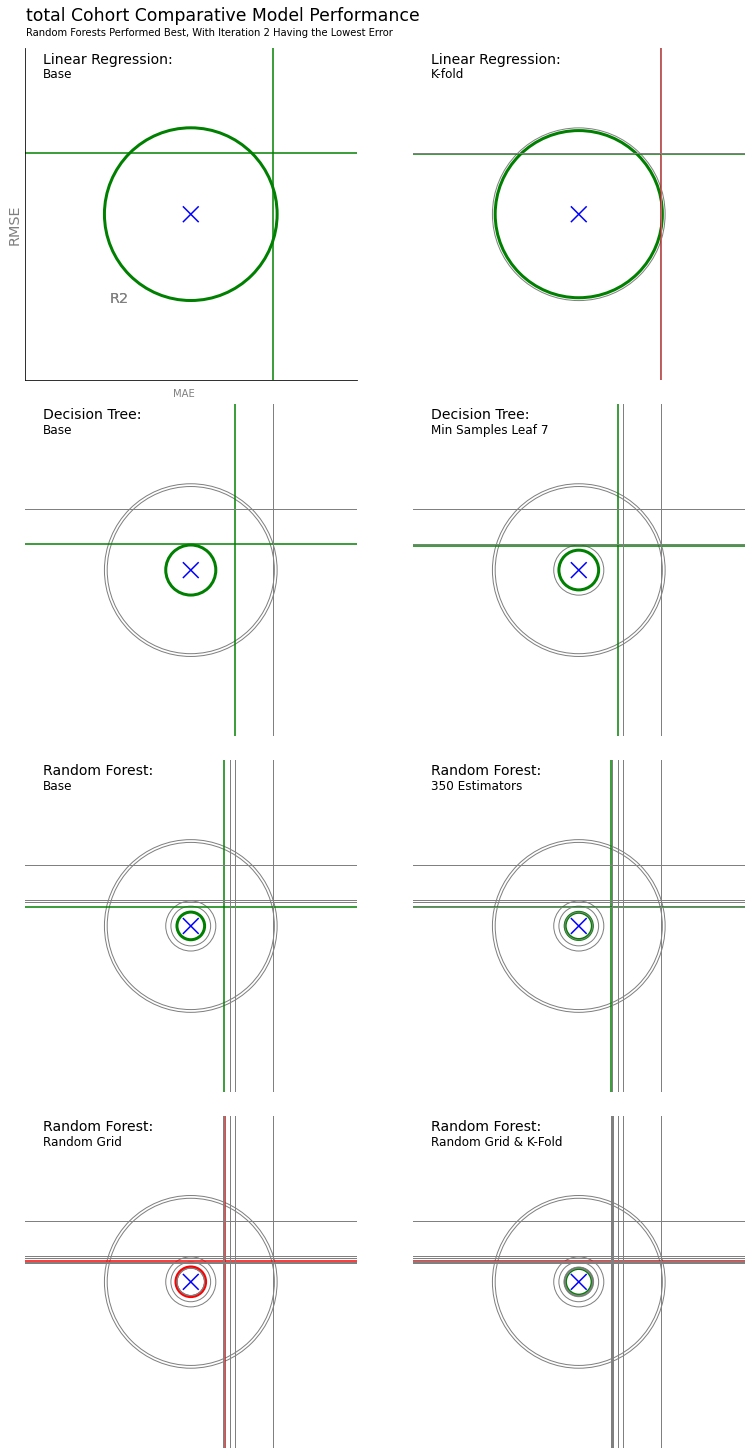

In [67]:
shooting_gallery(total_performance, 
                 insight = 'Random Forests Performed Best, With Iteration 2 Having the Lowest Error',
                 )

The best performing model for the total cohort was random forests with 350 estimators. While the random grid with k-fold did improve R2, it was to the detriment of RMSE and MAE.

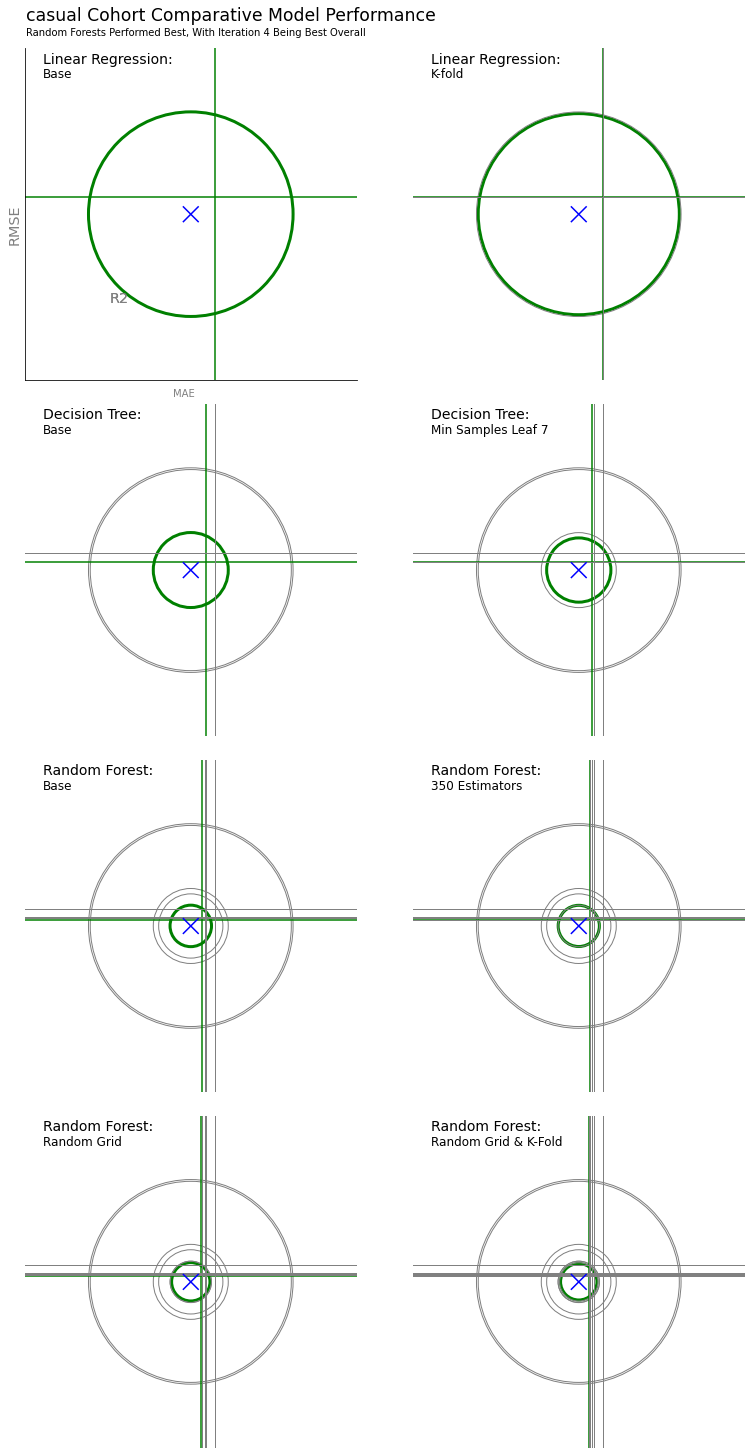

In [68]:
shooting_gallery(casual_performance, 
                 insight = 'Random Forests Performed Best, With Iteration 4 Being Best Overall',
                 )

Every iteration of the model improved the accuracy and precision of predictions with our last iteration with random grid and k-fold performing best for the casual cohort.

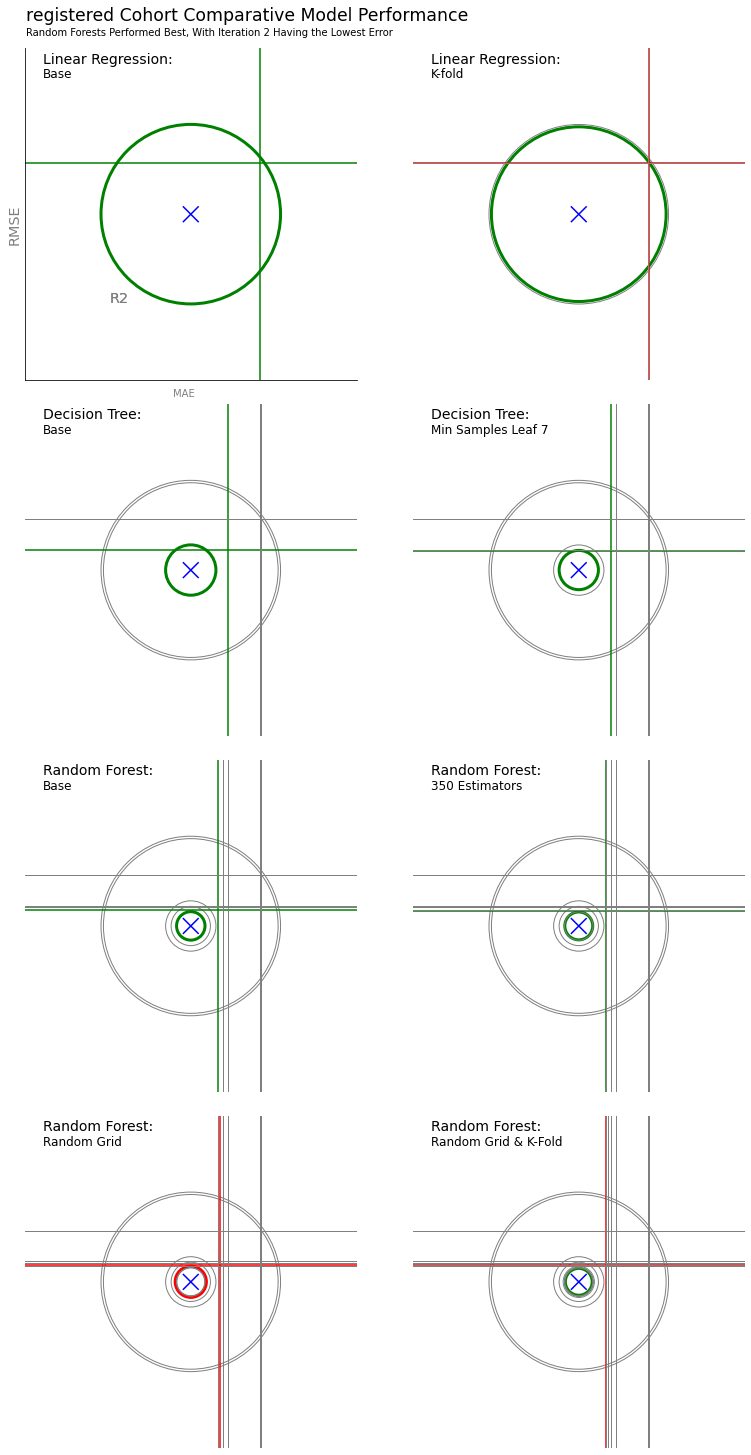

In [69]:
shooting_gallery(registered_performance, 
                 insight = 'Random Forests Performed Best, With Iteration 2 Having the Lowest Error',
                 )

Mirroring the total cohort almost exactly, the best performing model for the registered cohort was random forests with 350 estimators. While the random grid with k-fold did improve R2, it was to the detriment of RMSE and MAE.

## Conclusion
### Data Set Analysis
* There are more rentals in 2012 than 2011, research shows that Washington D.C. expanded their bikeshare program at the end of 2011.
* Warm weather increases rentals and peaks in Summer Months
* Registered and casual user groups have an inverse weekday/weekend relationship, with registered users having consistent usage throughout the work week.
* Registered user rentals peak during commuting hours (7:00-9:00 a.m. and 6:00-7:00 p.m.).
* Casual user rentals follow a normal distribution between 7:00 am and midnight with peak usage between noon and 6:00 p.m.
* Extreme weather causes a drop in bikeshare usage, though registered users are more resilient. 

### Predictive Models
Our goal was to create a predictive regression model for bike rental demand for our three cohorts (total count, registered count, and casual count). We used three algorithms (linear regression, decision trees, and random forests). Our success metrics were RMSE, MAE, and R2. 

#### Performance
* Random Forests performed best
    * Best model for total prediction:
        * Random Forest with 350 estimators - RMSE: 44.90, MAE: 26.04 , R2: 0.94
    * Best model for casual prediction:
        * Random Forest with random grid hyperparameter selection & k-fold - RMSE: 14.14, MAE: 8.35, R2: 0.91
    * Best model for registered prediction:
        * Random Forest with 350 estimators - RMSE: 37.13, MAE: 20.96, R2: 0.94 
        
Predicting the total users is more accurate than trying to predict the casual and registered user groups. Across all models, the R2 for the casual group was slightly lower than that of total and registered. This indicates that the models are less able to explain the variance in predictions with the features used, and there is an opportunity to improve the predictions with further feature engineering targeted at the casual group. 